## Soru 1: Ürün Etki Analizi

**A- UI açısından, ekranda yapılacak değişikliklerin satın alma davranışını
etkilemesi mümkün müdür?**

Evet mümkündür. Kullanıcı arayüzü üzerinde yapılan değişikliklerin kullanıcı davranışlarını etkilemesi mümkündür ve satın alma bu davranışlardan birisidir. Özellikle akış üzerine eklenecek adım yada eklenecek fazladan bir seçenek satın alma oranlarını değiştirebilir. 

**B- UI değişikliklerinin potansiyel etkisini, değişikliği yayına almadan önce
yukarıda bahsedilen kullanıcı hareketleri verisinden çıkarılması nasıl
sağlanabilir?**



Birinci adımda diğer checkbox'ların verilerine bakarak ekleyeceğimiz checkbox'ın sonuçlarını çıkarmak için öncelikle checkbox'ı işaretledikten sonra açılacak sayfanın ne olduğunu bilmemiz gerekir. 

1. Checkbox işaretlendikten sonra yeni bir sayfaya yönlendirilecek ve/veya bir mesaj gelecekse davranışları 3DS ile yakınlık gösterecektir.
2. Checkbox işaretlendikten sonra sayfada taksit seçenekleri gibi ekstra bir seçim panosu açılacaksa davranışları Taksit checkbox'ı ile yakınlık gösterilecektir. 
3. Checkbox işaretlendikten sonra herhangi bir ektra aksiyon almamız gerekmiyorsa ad, soyad textbox'ları ile yakınlık gösterebilir. 

İkinci adımda hangi verileri nasıl yorumlamalıyız?

Aslında çıkarım yapmak istediğimiz asıl veri conversion rate. Elimizdeki veriler ile sayfanın conversion rate'ini hesaplayabiliriz ancak içerisindeki bir elementin etkisini anlamaya çalışmamız gerekiyor. 

1. Elimizde varsa diğer checkboxların A/B test sonuçları bizi sonuca götürebilir.
2. Bu sayfada seçtiğimiz checkbox'a hiç dokunmamış kullanıcıların conversion rate'ini checkbox'a tıklayanlar ile karşılaştırmak checkbox'ın etkisini bize gösterecektir.
3. Checkbox'a tıklayıp ardından sayfayı terk edenlerin oranlarına bakmak.


**C- "Yeni" isimli checkbox yerleştirildikten ve canlıya alındıktan sonra, yapılan
değişikliğin ödeme davranışına etkisi ne gibi bir etki testi ile ölçülebilir?**

Üründe yapılan bir değişikliğin sonuçlarını ölçmek için A/B test yapmamız gerekir. Temelde ana grubu iyi yansıttığını düşündüğümüz gruplara sayfanın yeni halini gösterip conversion rate'leri ölçümlememiz gerekiyor. Bu deneyin daha sağlıklı sonuçlar vermesi için örnek grupların sayısını arttırmamız gerekir. Bu sayede confidence interval'ı daha yüksek bir test yapmış oluruz. 

## Soru 2: Öznitelik Oluşturma

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv("Dataset.csv")

In [3]:
df

,transaction_id,email,is_fraud
0,1,david@gmail.com,0
1,2,david@gmail.com,0
2,3,ryan@hotmail.com,1
3,4,andy@yahoo.com,1
4,5,peter@gmail.com,1
5,6,andy@yahoo.com,0
6,7,andy@yahoo.com,1
7,8,ryan@hotmail.com,0
8,9,teddy@iyzico.com,1
9,10,ryan@hotmail.com,1


##### Fonksiyonlar

Veriyi oluştururken veri setinin tamamından değil gelen işlemden önceki işlemleri göz önünde bulundurun bir yaklaşım izledim. Kredi kartından sahtekarlık saptama işlemi bulk veri ile değilde o veri geldiği anda yapıldığı için böyle bir yaklaşım izledim. 

1. CountFraud

        Bu fonksiyon her bir işlem için aynı kullanıcının daha önce kaç adet fraudlu işlem yaptığını hesaplıyor.
    
     
2. CountOrder

        Kullanıcının bu işleme kadar yaptığı toplam işlem sayısı
    
     
3. FraudRate

        Kullanıcının yaptığı fraud sayısı/toplam sipariş sayısı
    
    
4. FirstTimer

        Kullanıcının ilk alışverişi olup olmadığına bakıyor
    
    
5. MailQuality

        Aşağıda belirttiğim kaynaktan aldığım ve herkes tarafından elde edilebilir mailler ile kullanıcıların maillerini karşılaştırdım. mailleri public yada değil şeklinde işaretledim.
    

6. Frequency

        Son 5 işlemin kaçının bu kullanıcıyaait olduğunu çıkardım. Normal şartlarda bunu zaman tagleri üzeirnden yapmak daha sağlıkllı olurdu ancak elde veri ile bu tarz bir yaklaşım geliştirdim.
    
    
7. PrepareData

        Dİğer fonksiyonların tamamını çalıştırıp veriyi son haline getirdiğim fonksiyon.

In [4]:
def CountFraud(df):
    if "count_fraud" not in df.columns:
        df["count_fraud"]=0
    
    for i in range(1,len(df)+1):
        df["count_fraud"][i-1]=np.sum((df[(df.transaction_id<i) & (df.email==df.iloc[i-1,1])].is_fraud))

In [5]:
def CountOrder(df):
    if "order_count" not in df.columns:
        df["order_count"]=0
    
    for i in range(1,len(df)+1):

        df["order_count"][i-1]=len(df[(df.transaction_id<i) & (df.email==df.iloc[i-1,1])]) 

In [6]:
def FraudRate(df):
    if "fraud_rate" not in df.columns:
        df["fraud_rate"]=0
    
    for i in range(1,len(df)+1):

        df["fraud_rate"][i-1]=df["count_fraud"][i-1]/len(df[(df.transaction_id<i) & (df.email==df.iloc[i-1,1])])
    df.fillna(0,inplace=True)

In [7]:
def FirstTimer(df):
    if "first_time" not in df.columns:
        df["first_time"]=0
        
    for i in range(1,len(df)+1):
        if df["order_count"][i-1] >0: 
            df["first_time"][i-1]=0
        else:
            df["first_time"][i-1]=1    
       

In [8]:
def MailQuality(df):
    domains = [
    # Default domains included */
    "aol.com", "att.net", "comcast.net", "facebook.com", "gmail.com", "gmx.com", "googlemail.com",
    "google.com", "hotmail.com", "hotmail.co.uk", "mac.com", "me.com", "mail.com", "msn.com",
    "live.com", "sbcglobal.net", "verizon.net", "yahoo.com", "yahoo.co.uk",
    
    # Other global domains */
    "email.com", "fastmail.fm", "games.com" , "gmx.net", "hush.com", "hushmail.com", "icloud.com",
    "iname.com", "inbox.com", "lavabit.com", "love.com" , "outlook.com", "pobox.com", "protonmail.ch", "protonmail.com", "tutanota.de", "tutanota.com", "tutamail.com", "tuta.io",
    "keemail.me", "rocketmail.com" , "safe-mail.net", "wow.com", "ygm.com",
    "ymail.com" , "zoho.com", "yandex.com",
    
    # United States ISP domains */
    "bellsouth.net", "charter.net", "cox.net", "earthlink.net", "juno.com",
    
    # British ISP domains */
    "btinternet.com", "virginmedia.com", "blueyonder.co.uk", "freeserve.co.uk", "live.co.uk",
    "ntlworld.com", "o2.co.uk", "orange.net", "sky.com", "talktalk.co.uk", "tiscali.co.uk",
    "virgin.net", "wanadoo.co.uk", "bt.com",
    
    # Domains used in Asia */
    "sina.com", "sina.cn", "qq.com", "naver.com", "hanmail.net", "daum.net", "nate.com", "yahoo.co.jp", "yahoo.co.kr", "yahoo.co.id", "yahoo.co.in", "yahoo.com.sg", "yahoo.com.ph", "163.com", "yeah.net", "126.com", "21cn.com", "aliyun.com", "foxmail.com",
    
    # French ISP domains */
    "hotmail.fr", "live.fr", "laposte.net", "yahoo.fr", "wanadoo.fr", "orange.fr", "gmx.fr", "sfr.fr", "neuf.fr", "free.fr",
    
    # German ISP domains */
    "gmx.de", "hotmail.de", "live.de", "online.de", "t-online.de" , "web.de", "yahoo.de",
    
    # Italian ISP domains */
    "libero.it", "virgilio.it", "hotmail.it", "aol.it", "tiscali.it", "alice.it", "live.it", "yahoo.it", "email.it", "tin.it", "poste.it", "teletu.it",
    
    # Russian ISP domains */
    "mail.ru", "rambler.ru", "yandex.ru", "ya.ru", "list.ru",
    
    # Belgian ISP domains */
    "hotmail.be", "live.be", "skynet.be", "voo.be", "tvcablenet.be", "telenet.be",
    
    # Argentinian ISP domains */
    "hotmail.com.ar", "live.com.ar", "yahoo.com.ar", "fibertel.com.ar", "speedy.com.ar", "arnet.com.ar",
    
    # Domains used in Mexico */
    "yahoo.com.mx", "live.com.mx", "hotmail.es", "hotmail.com.mx", "prodigy.net.mx",
    
    # Domains used in Brazil */
    "yahoo.com.br", "hotmail.com.br", "outlook.com.br", "uol.com.br", "bol.com.br", "terra.com.br", "ig.com.br", "itelefonica.com.br", "r7.com", "zipmail.com.br", "globo.com", "globomail.com", "oi.com.br"
    ]
    
    if "public_mail" not in df.columns:
        df["public_mail"]=0
    
    for i in range(len(df)):
        match = re.search(r'@[\w\.-]+', df["email"][i])
        match.group(0)
        
        if match.group(0)[1:] in domains:
            df["public_mail"][i]=1
        else:
            df["public_mail"][i]=0

In [9]:
def frequency(df):
    if "frequency" not in df.columns:
        df["frequency"]=0
        
    for i in range(1,len(df)+1):
        df["frequency"][i-1]=len(df[(df.transaction_id>i-5)&(df.transaction_id<i) & (df.email==df.iloc[i-1,1])]) 

In [10]:
def PrepareData(df):
    CountFraud(df)
    CountOrder(df)
    FraudRate(df)
    FirstTimer(df)
    MailQuality(df)
    frequency(df)
    df=df[['transaction_id', 'email', 'count_fraud', 'fraud_rate',
       'order_count', 'first_time', 'public_mail', 'frequency','is_fraud']]
    return(df)

In [11]:
frequency(df)

In [12]:
df=PrepareData(df)

In [13]:
df

,transaction_id,email,count_fraud,fraud_rate,order_count,first_time,public_mail,frequency,is_fraud
0,1,david@gmail.com,0,0.000000,0,1,1,0,0
1,2,david@gmail.com,0,0.000000,1,0,1,1,0
2,3,ryan@hotmail.com,0,0.000000,0,1,1,0,1
3,4,andy@yahoo.com,0,0.000000,0,1,1,0,1
4,5,peter@gmail.com,0,0.000000,0,1,1,0,1
5,6,andy@yahoo.com,1,1.000000,1,0,1,1,0
6,7,andy@yahoo.com,1,0.500000,2,0,1,2,1
7,8,ryan@hotmail.com,1,1.000000,1,0,1,0,0
8,9,teddy@iyzico.com,0,0.000000,0,1,0,0,1
9,10,ryan@hotmail.com,1,0.500000,2,0,1,1,1


## Soru 3: Sınıflandırma

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split # Split data as test and train test size=0.3

In [16]:
mldf=df.iloc[:,2:]

In [ ]:
sns_plot=sns.countplot(x='is_fraud', data=mldf).get_figure()
#Balaced enough

In [ ]:
corr = mldf.corr()

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

In [17]:
# drop order_count to stay away from multicolinarity
mldf.drop(columns=['order_count'],inplace=True)

###### Veriyi ilk denemede test ve train olarak ayırdım ancak veri setinin küçüklüğü anlamsız sonuçlar bulmamıza sebep oldu.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(mldf.drop('is_fraud',axis=1), mldf['is_fraud'], test_size=0.50, random_state=101)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
pred_rfc = dtc.predict(X_test)
print(confusion_matrix(y_test, pred_rfc))
print(classification_report(y_test, pred_rfc))
print(accuracy_score(y_test, pred_rfc))

[[1 2]
 [1 3]]
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7

0.5714285714285714


###### İkinci denemede verinin tamamını hem eğitmek hemde test etmek için kullandım. Normal şartlarda bu tarz bir test için geçerli diyemeyiz ancak en azından test skorlarını görebildim. 

In [19]:
y=['is_fraud']
X=[i for i in mldf if i not in y]
y=mldf[y]
X=mldf[X]

In [20]:
dtc = DecisionTreeClassifier()
dtc.fit(X, y)
pred_rfc = dtc.predict(X) 
print(confusion_matrix(y, pred_rfc))
print(classification_report(y, pred_rfc))
print(accuracy_score(y, pred_rfc))

[[5 1]
 [2 6]]
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.86      0.75      0.80         8

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.80      0.79      0.79        14

0.7857142857142857


In [22]:
dtc.predict(X) 

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

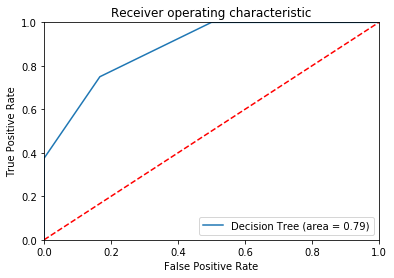

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y, dtc.predict(X))
fpr, tpr, thresholds = roc_curve(y, dtc.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [27]:
fpr, tpr, thresholds = roc_curve(y, dtc.predict_proba(X)[:,1])

In [28]:
fpr

array([0.        , 0.        , 0.16666667, 0.5       , 1.        ])

In [29]:
thresholds

array([2.  , 1.  , 0.75, 0.5 , 0.  ])

## Soru 4: Yazılı Anlatım

Yüksek lisans programı kapsamında aldığım Big Data dersinde yaptığım, 1.6 TB'lık veri ile çalıştığım proje bugüne kadar en zorlandığım projeydi.Projenin zorlayıcı olmasının ana sebebi projeyi tamamlamak için ihtiyacım olan bir çok teknik yeterliliğin daha önce tecrübe etmediğim alanlarda oluşuydu. 

Projeyi tamamlamak için adımlar;
    
1. Microsoft Azure üzerinde bulunan 1.6 TB'lik datanın S3 Bucketlara taşınması
2. Bu veriyi işleyebileceğim parallel computing clusterlarının ayağa kaldırılması
3. S3 Bucket ile clusterların birbirine bağlanması 
4. Pyspark ile verimliliği yüksek bir kod yazılması

Bu maddelerin sırası ile benim için neden zor oldukları;

1. Veri toplam 24 parça halinde bulunuyordu. S3 Bucketa veriyi çektikten sonra açmak mümkün olmadığı için önce yüksek kapasiteli bir EC2 açıp terminal üzerinden her parçayı indirip açıp sonrasın S3'ye yüklemem gerekti.
2. EMR clusterları oldukça maliyetli ürünler oldukları için yerel makinamda pseudo cluster Hadoop ve Spark kurmam gerekti. Böylece verinin küçük bir kısmı ile kodumu hazırlayıp sonrasında gerçek EMR clusterlar üzerinde çalıştırabilecektim. Ancak yerel makina üzerine bu programları kurmak için ciddi seviyede bash scripting yapmam gerekti.
3. Normal şartlarda S3 bucketları bir makineye bağlamak istediğinizde IAM role adında bir yetki ile ilerlemeniz gerekiyordu. Ancak kullandığımız hesabın en üst seviye adminleri yüksek lisansa sponsor olan şirketin verilerinede ulaşabileceğimiz için bu rolü bizlere tanımlayamıyorlardı. Sonuç olarak S3 Bucketlar'ı tamamen public yaparak bir link üzerinden bağlandım. Ancak bu çözümü bulmak zaman aldı.
4. Alışık olduğum Python dilinde bulunmayan RDD ve Dataframe formatları ile çalışmam gerekti. Buna ek olarak Pyspark üzerinde kodlama yaparken alışık olduğum high level python dilinden farklı olarak clusterların yönetiminide sizin yapmanız gerekiyor. Parralelization, mapreduce, broadcasting gibi performans odaklı fonksiyonlar ile çalışmam gerekti.

Bu projede oldukça tecrübesiz olduğum altyapı problemleri olduğu için problemleri çözmeden önce tanımlamam gerekti. Bu kısımda daha çok hocalara danışıp aynı problemleri yaşayan sınıf arkadaşlarım ile konuştum. Ardından ilk 3 problemi Google üzerinde çok sayıda arama yaparak çözdüm. Özellikle konu derinleştikçe çözüm sunan tek kaynak stackoverflow.com ve dökümanlar oldu. 4. problem ise diğerleri gibi tek problemi çözmekten öte bütün konsepte hakim olmayı gerektiren bir problemdi. Bu sebep ile pluralsight.com üzerinden aldığım bir ders ile bilgi birikimimi arttırarak bu problemi çözdüm. 